In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [14]:
df = pd.read_csv('dataforreg(2).csv')
df['ret'] = df.groupby('S_INFO_WINDCODE')['S_DQ_CLOSE'].pct_change()
df = df.dropna()
df = df.sort_values(by=['TRADE_DT','S_INFO_WINDCODE'])
df.reset_index(drop = True, inplace = True)
df['TRADE_DT'] = pd.to_datetime(df['TRADE_DT'])
df

,S_INFO_WINDCODE,TRADE_DT,S_DQ_CLOSE,S_FA_ROE,Skewness20,WVAD,S_VAL_PS,NET_ASSETS_TODAY,TOT_CUR_LIAB,ret
0,000100.SZ,2017-02-07,3.50,6.8212,0.803810,-3.509719e+05,0.4088,2.538541e+10,6.729310e+10,-0.008499
1,000425.SZ,2017-02-07,3.42,2.6604,-0.446580,7.877827e+05,1.4387,2.038995e+10,2.076411e+10,0.014837
2,000651.SZ,2017-02-07,25.13,30.4205,0.920298,7.536173e+04,1.5466,4.974506e+10,1.268763e+11,-0.005146
3,002352.SZ,2017-02-07,42.02,39.4012,-0.675897,-1.855552e+04,262.9876,7.064836e+08,1.838696e+10,0.001669
4,002466.SZ,2017-02-07,33.48,39.4599,1.789500,-3.128026e+04,17.8337,4.338934e+09,2.968776e+09,-0.024476
...,...,...,...,...,...,...,...,...,...,...
12921,002466.SZ,2022-07-01,133.00,15.4520,0.427623,8.352788e+05,25.6357,1.656121e+10,2.507958e+11,0.065705
12922,600048.SH,2022-07-01,17.52,6.3449,0.289253,9.681472e+05,0.7360,1.792595e+11,1.520011e+09,0.003436
12923,600276.SH,2022-07-01,38.94,8.0614,0.079993,2.764268e+06,9.5886,3.624272e+10,3.650926e+10,0.049879
12924,600519.SH,2022-07-01,2029.05,26.2935,0.307598,4.486159e+04,24.0031,1.795549e+11,1.490745e+10,-0.007800


In [15]:
timestep = 1  # 时间步长，就是利用多少时间窗口
batch_size = 32  # 批次大小
input_dim = 8 # 每个步长对应的特征数量，就是使用每天的8个特征
hidden_dim = 64  # 隐层大小
output_dim = 1  # 由于是回归任务，最终输出层大小为1
num_layers = 3  # LSTM的层数
epochs = 300
best_loss = 0
model_name = 'gru'
save_path = './{}.pth'.format(model_name)

In [16]:
# 形成训练数据，例如12345变成12-3，23-4，34-5
def split_data(data, timestep):
    dataX = []  
    dataY = []

    # 将整个窗口的数据保存到X中，将未来一天保存到Y中
    for index in range(len(data) - timestep):
        dataX.append(data[index: index + timestep])
        dataY.append(data[index + timestep][-1])

    dataX = np.array(dataX)
    dataY = np.array(dataY)

    # 获取训练集大小
    train_size = int(np.round(0.8 * dataX.shape[0]))
    vali_size = int(np.round(0.1 * dataX.shape[0]))

    # 划分训练集、测试集
    x_train = dataX[: train_size, :].reshape(-1, timestep, 8)
    y_train = dataY[: train_size]
    
    x_vali = dataX[train_size: train_size + vali_size, :].reshape(-1, timestep, 8)
    y_vali = dataY[train_size:train_size + vali_size]
    
    x_test = dataX[train_size + vali_size:, :].reshape(-1, timestep, 8)
    y_test = dataY[train_size + vali_size:]

    return [x_train, y_train, x_vali, y_vali, x_test, y_test]

In [17]:
# 7.定义LSTM网络
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim  # 隐层大小
        self.num_layers = num_layers  # LSTM层数
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, h_n = self.gru(x) 
        batch_size, timestep, hidden_dim = output.shape

        # 将output变成 batch_size * timestep, hidden_dim
        output = output.reshape(-1, hidden_dim)
        output = self.fc(output)  # 形状为batch_size * timestep, 1
        output = output.reshape(timestep, batch_size, -1)
        return output[-1]  # 返回最后一个时间片的输出

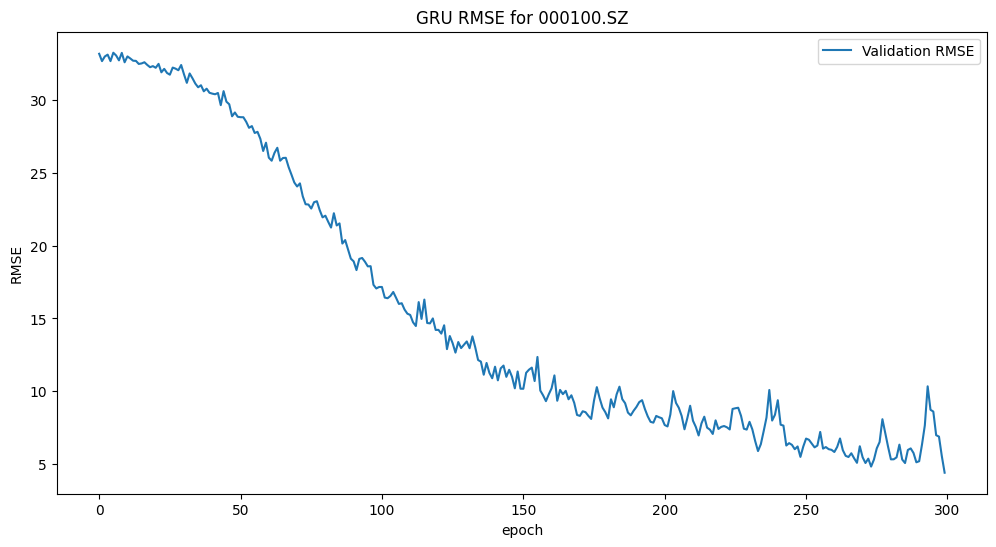

Done!


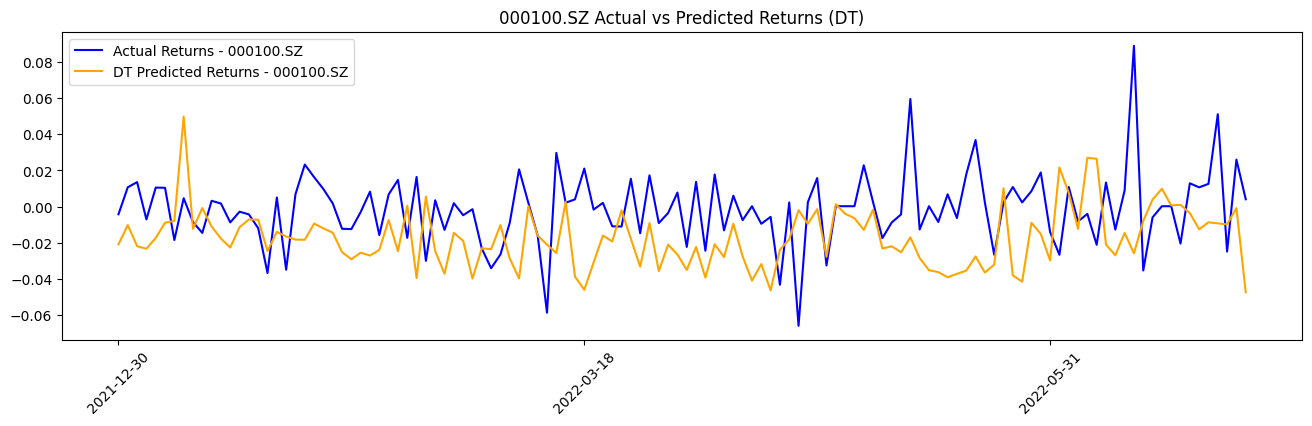

mse: 0.00095100317
mae: 0.024770807
mape: 6.792798
rmse: 0.030838339
r2: -1.3312974750481334


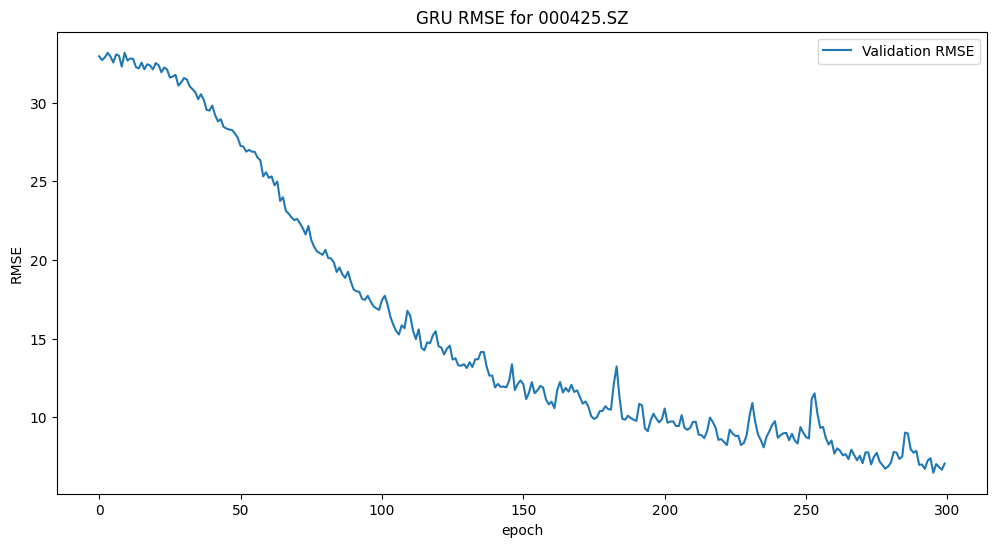

Done!


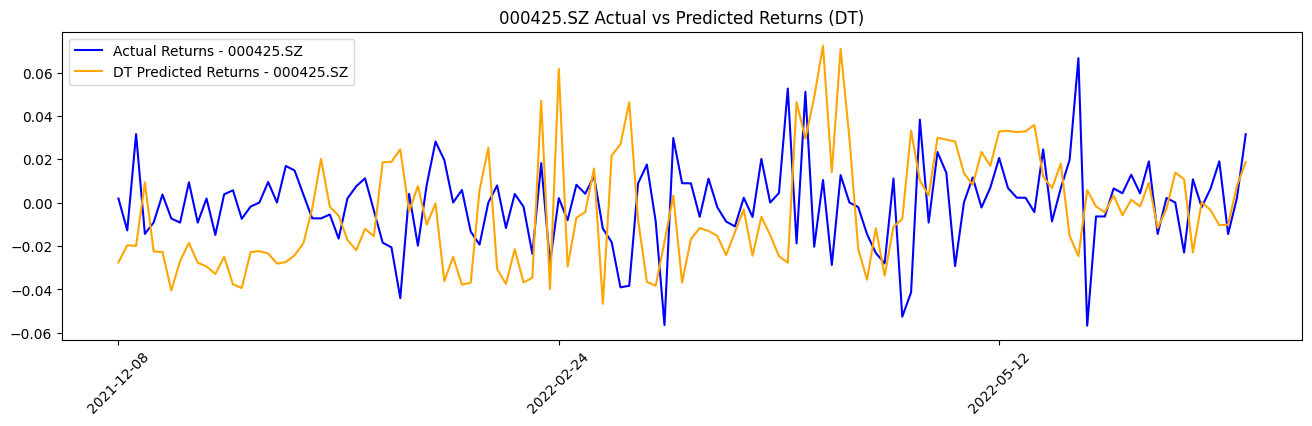

mse: 0.0010692262
mae: 0.026655167
mape: 20.097162
rmse: 0.032699022
r2: -1.8415819081608018


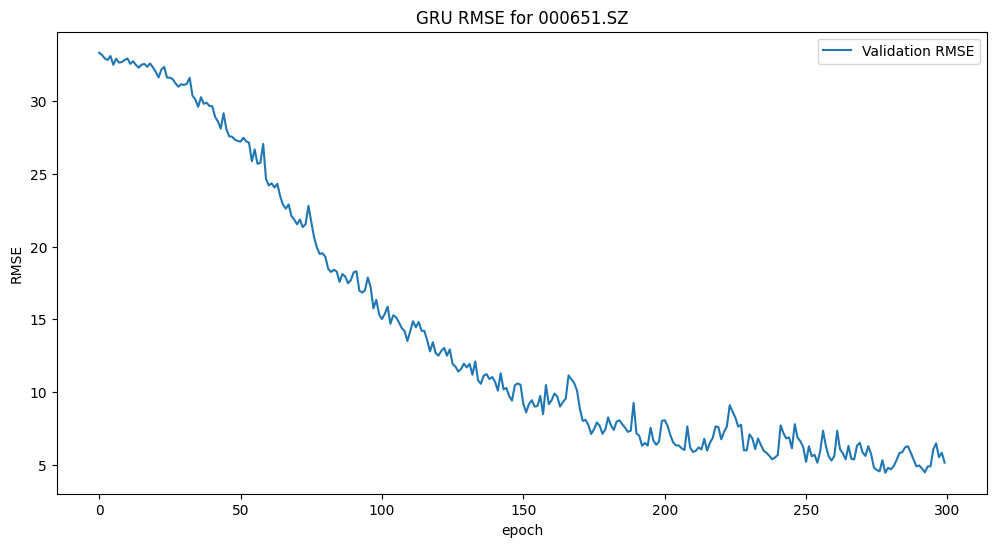

Done!


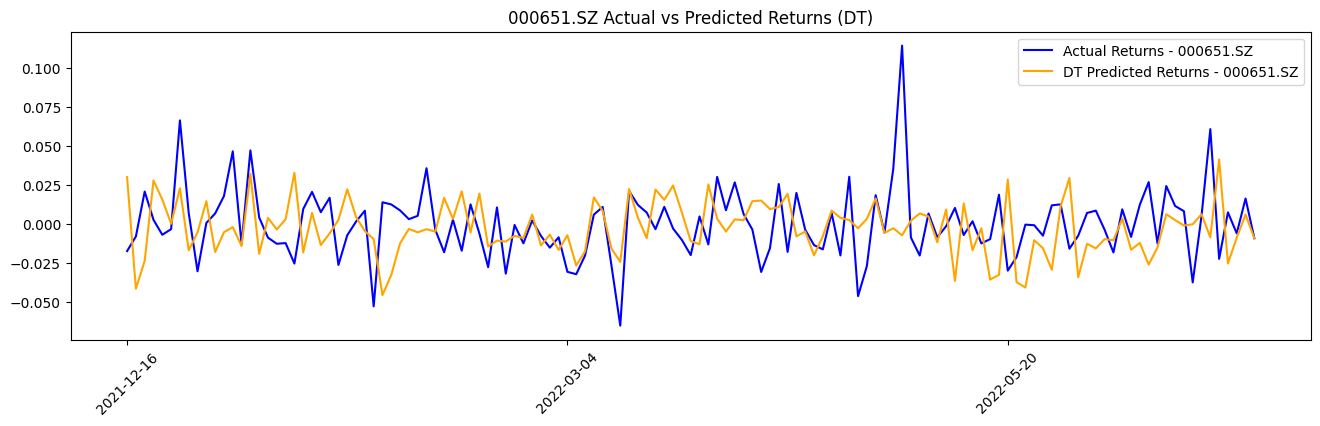

mse: 0.00080262515
mae: 0.02161155
mape: 2.7853057
rmse: 0.028330639
r2: -0.5679462958057004


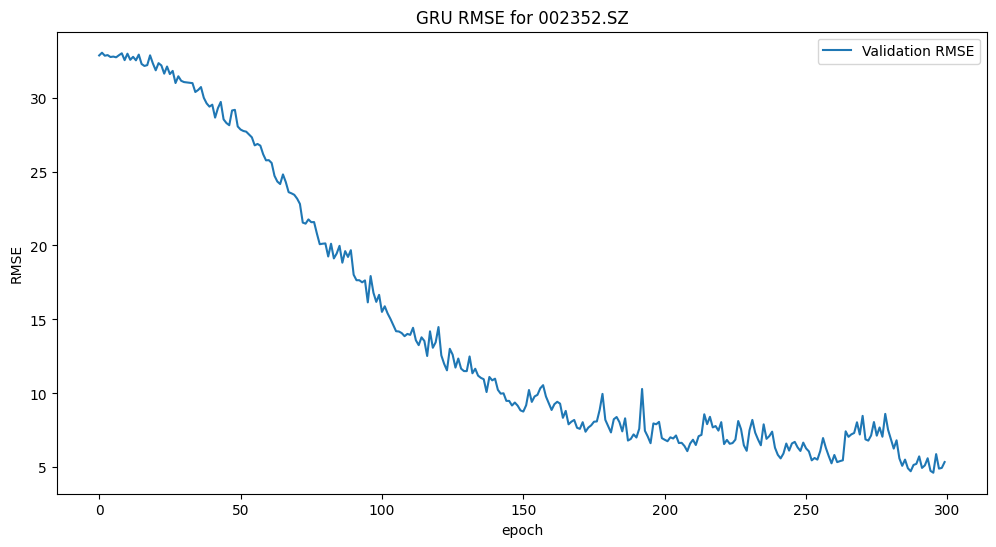

Done!


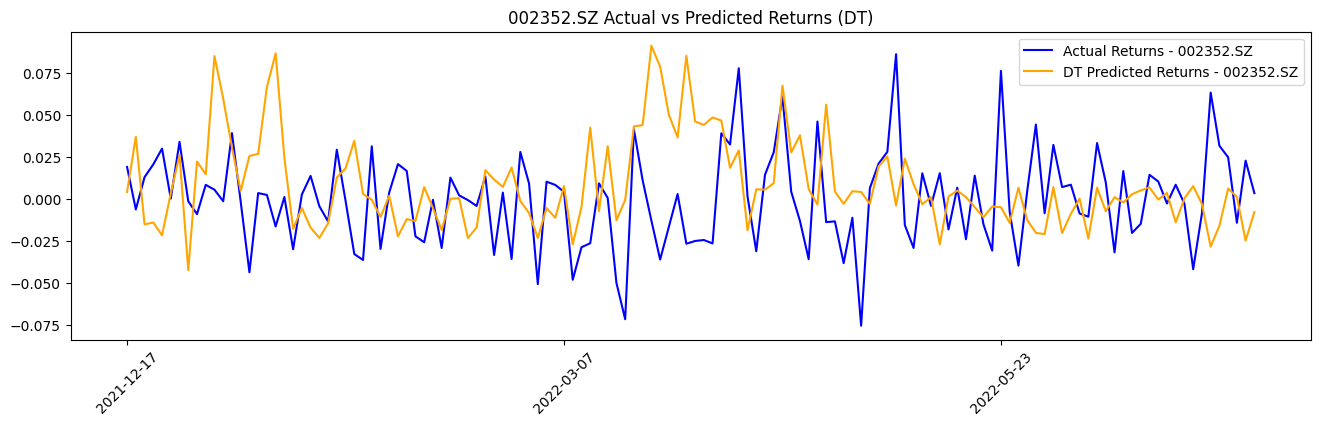

mse: 0.0016140337
mae: 0.030710414
mape: 3.7674723
rmse: 0.04017504
r2: -1.0854393549482277


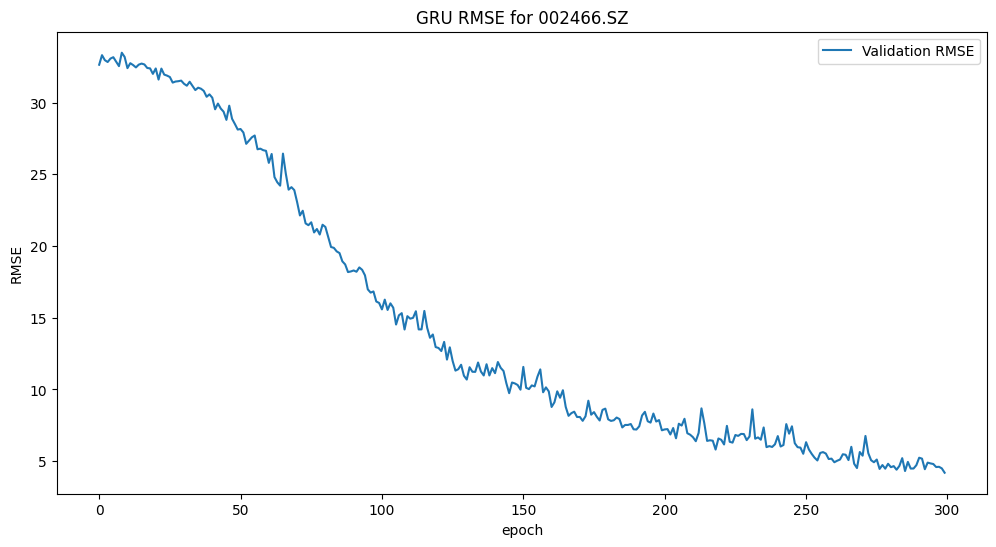

Done!


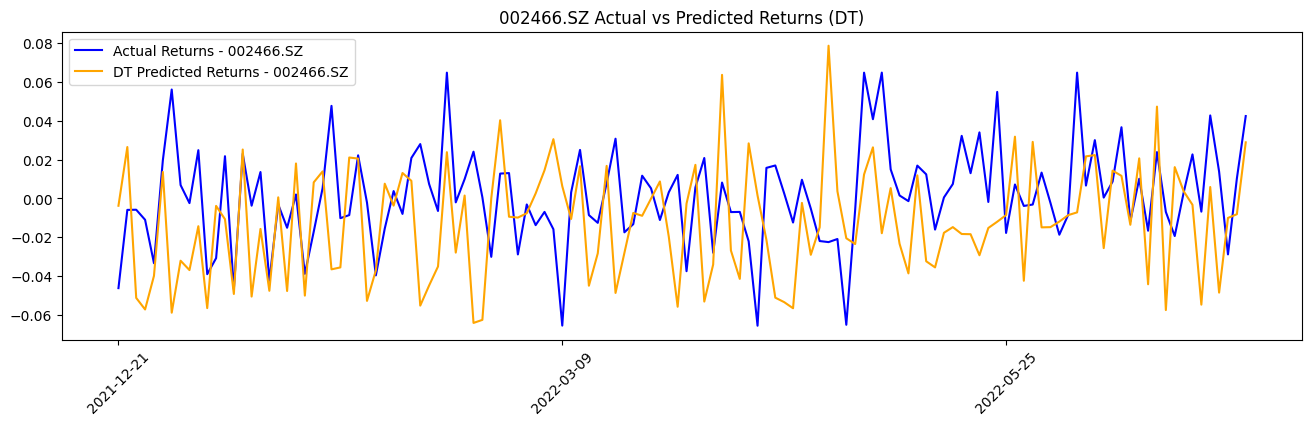

mse: 0.0014777882
mae: 0.030504543
mape: 4.6828303
rmse: 0.038442012
r2: -1.2960381736904742


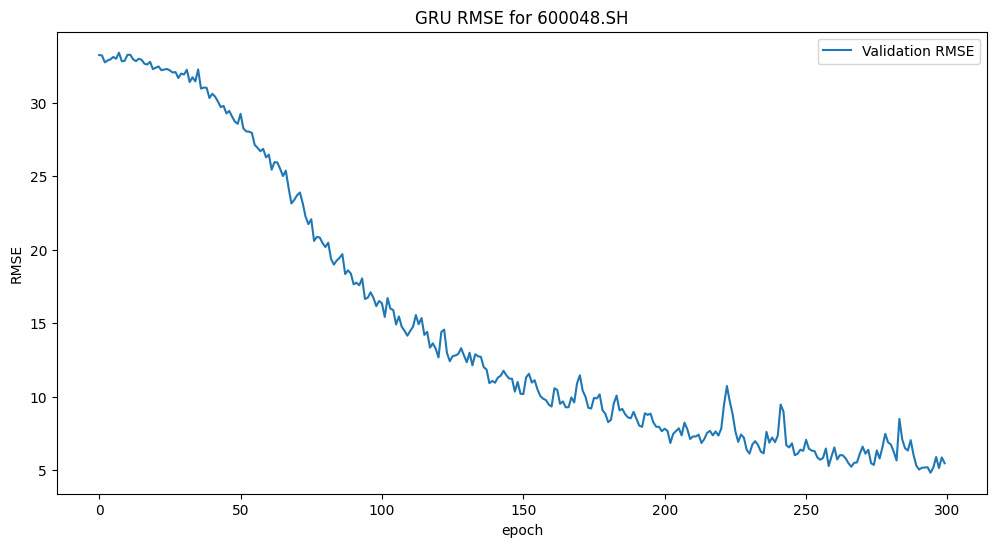

Done!


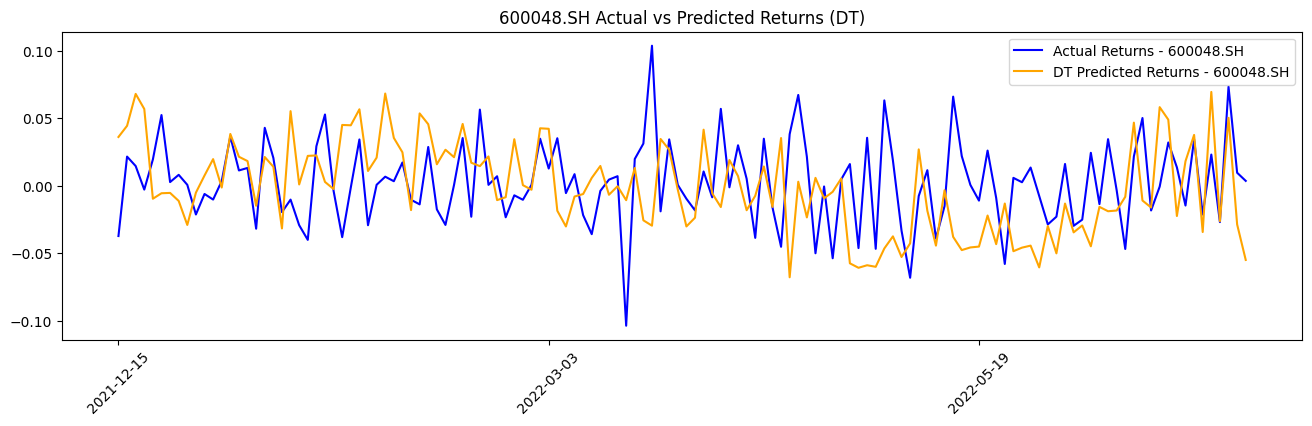

mse: 0.0018255592
mae: 0.0333897
mape: 4.9916506
rmse: 0.04272656
r2: -0.9009423029057197


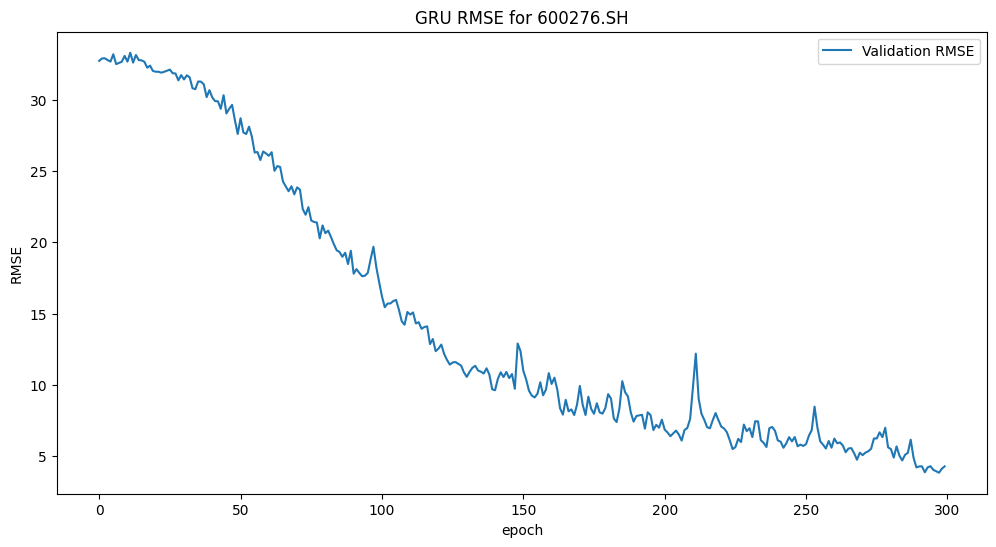

Done!


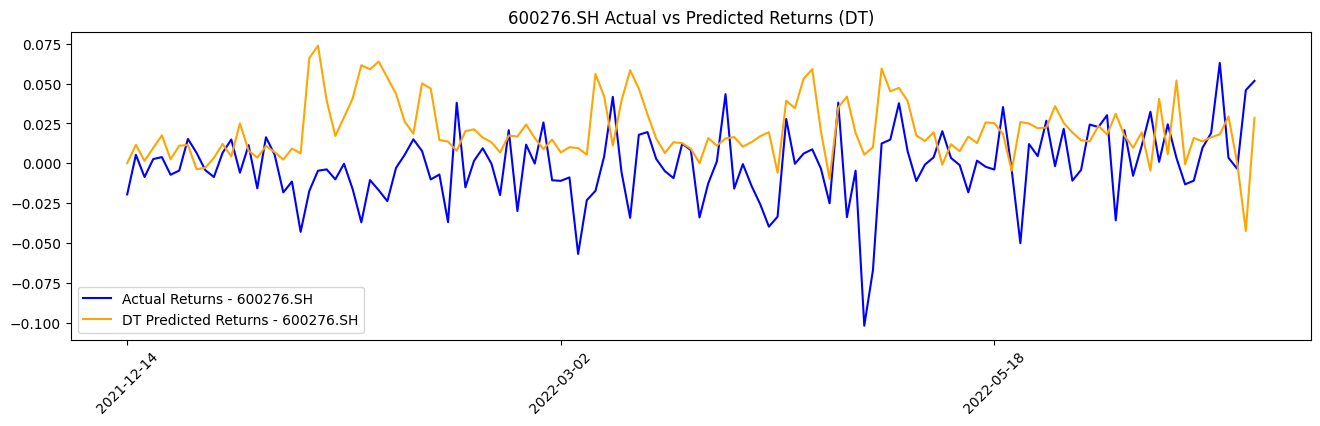

mse: 0.0013653602
mae: 0.02835586
mape: 7.274513
rmse: 0.036950782
r2: -1.5335834641132964


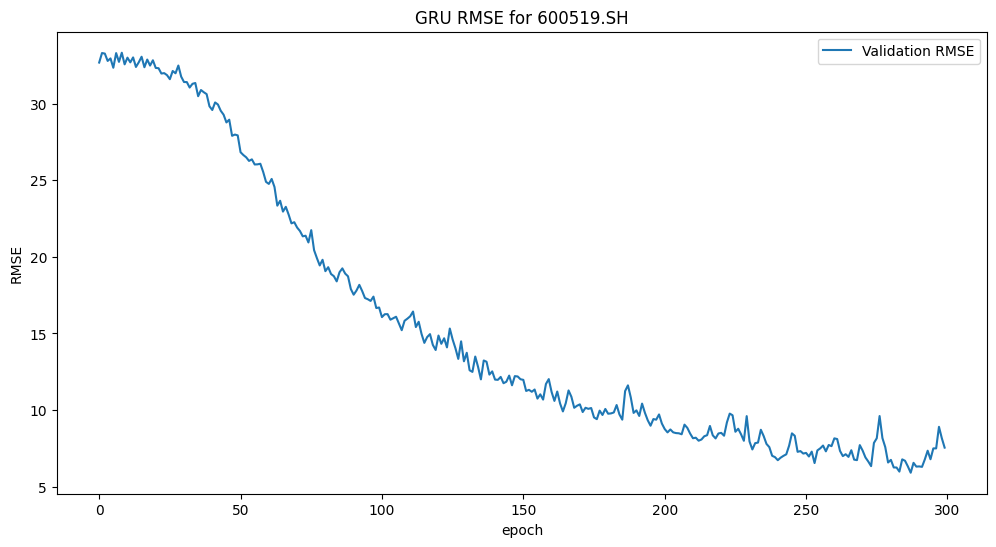

Done!


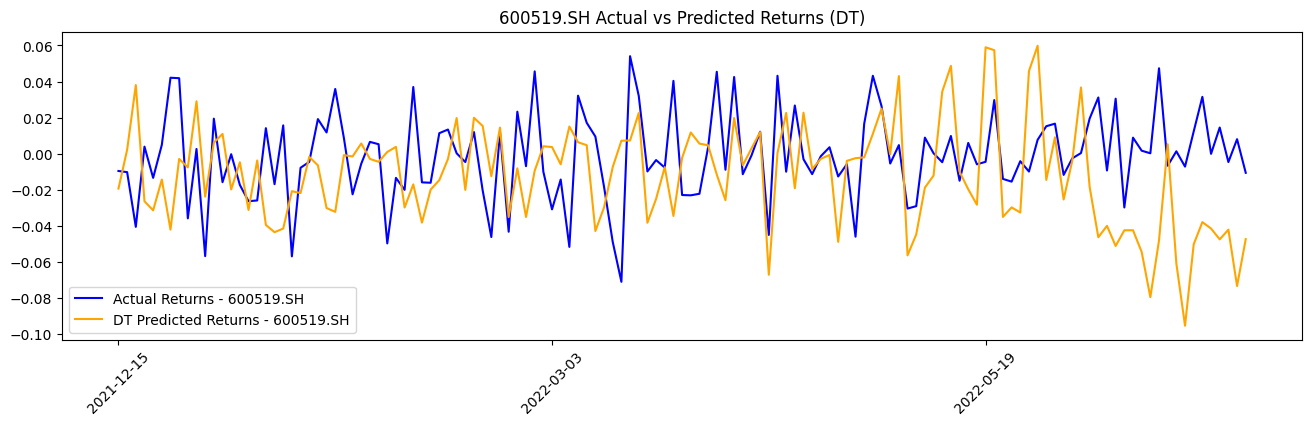

mse: 0.0014650183
mae: 0.030757427
mape: 13.141785
rmse: 0.03827556
r2: -1.459227984426139


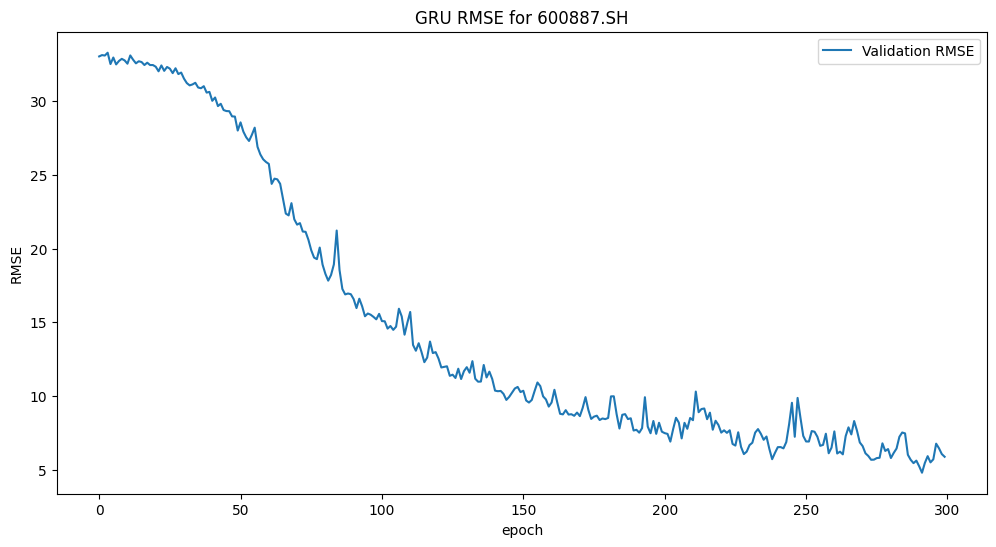

Done!


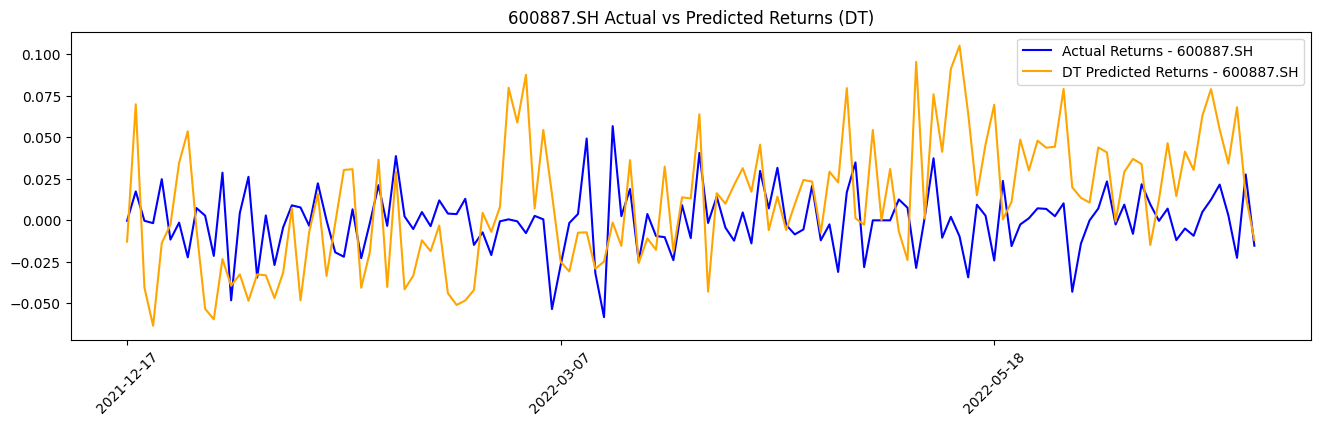

mse: 0.0017397027
mae: 0.03309935
mape: 15.614973
rmse: 0.041709743
r2: -3.7319795989039486


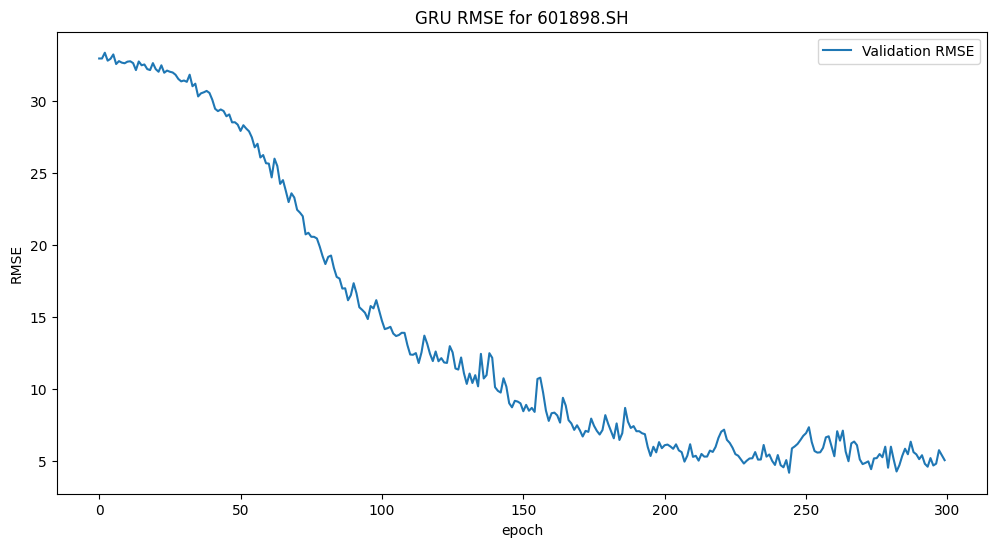

Done!


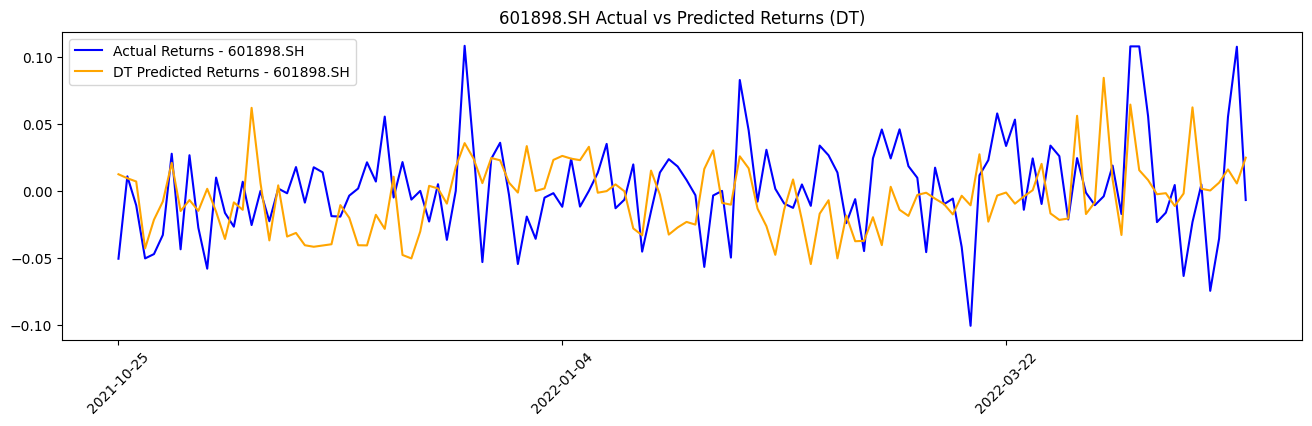

mse: 0.0017053674
mae: 0.03369735
mape: 9.882233
rmse: 0.041296095
r2: -0.35115731511311643


In [18]:
actual = []
predicted = []
for name in df['S_INFO_WINDCODE'].unique():
    stock_data = df[df['S_INFO_WINDCODE'] == name]
    # 将数据进行标准化
    scaler = StandardScaler()
    scaler_model = StandardScaler()
    data = scaler_model.fit_transform(np.array(stock_data.iloc[:,2:])).reshape(-1,8)
    scaler.fit_transform(np.array(df['ret']).reshape(-1, 1))
    
    # 获取训练数据   x_train: 1700,1,1
    x_train, y_train, x_vali, y_vali, x_test, y_test = split_data(data, timestep)

    # 将数据转为tensor
    x_train_tensor = torch.from_numpy(x_train).to(torch.float32)
    y_train_tensor = torch.from_numpy(y_train).to(torch.float32)
    x_vali_tensor = torch.from_numpy(x_vali).to(torch.float32)
    y_vali_tensor = torch.from_numpy(y_vali).to(torch.float32)
    x_test_tensor = torch.from_numpy(x_test).to(torch.float32)
    y_test_tensor = torch.from_numpy(y_test).to(torch.float32)

    # 形成训练数据集
    train_data = TensorDataset(x_train_tensor, y_train_tensor)
    vali_data = TensorDataset(x_vali_tensor, y_vali_tensor)
    test_data = TensorDataset(x_test_tensor, y_test_tensor)

    # 将数据加载成迭代器
    train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size,
                                            True)
    vali_loader = torch.utils.data.DataLoader(vali_data,
                                            batch_size,
                                            True)
    test_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size,
                                            False)

    # 模型训练
    model = GRU(input_dim, hidden_dim, num_layers, output_dim)  # 定义LSTM网络
    loss_function = nn.MSELoss()  # 定义损失函数
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)  # 定义优化器
    loss_s = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        # train_bar = tqdm(train_loader)  # 形成进度条
        for data in train_bar:
            x_train, y_train = data  # 解包迭代器中的X和Y
            optimizer.zero_grad()
            y_train_pred = model(x_train)
            loss = torch.sqrt(loss_function(y_train_pred, y_train.reshape(-1, 1)))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
            #                                                         epochs,
            #                                                         loss)
        # y_vali_pred = model(x_vali_tensor).detach().numpy()
        # rmse = mean_squared_error(y_vali_tensor.detach().numpy(), y_vali_pred, squared=False)
        loss_s.append(running_loss)

        # 模型验证
        model.eval()
        test_loss = 0
        with torch.no_grad():
            # test_bar = tqdm(test_loader)
            for data in test_bar:
                x_test, y_test = data
                y_test_pred = model(x_test)
                test_loss = loss_function(y_test_pred, y_test.reshape(-1, 1))

        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(model.state_dict(), save_path)

    plt.figure(figsize=(12,6))
    plt.plot(range(0, epochs), loss_s, label='Validation RMSE')
    plt.xlabel('epoch')
    plt.ylabel('RMSE')
    plt.title('GRU RMSE for ' + name)
    plt.legend()
    plt.show()  # 显示绘制的图形
    print("Done!")  # 训练结束

    y_test_pred = model(x_test_tensor)
    actuals = scaler.inverse_transform(y_test_tensor.detach().numpy().reshape(-1, 1))
    predictions = scaler.inverse_transform(y_test_pred.detach().numpy())

    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    x_range = np.arange(len(actuals)) 
    plt.figure(figsize=(16, 4))  
    plt.plot(x_range, actuals, label=f'Actual Returns - {name}', color='blue')
    plt.plot(x_range, predictions, label=f'DT Predicted Returns - {name}', color='orange')
    plt.legend()
    plt.xticks(x_range[::50], stock_data['TRADE_DT'][int(np.round(0.9 * stock_data.shape[0])):].dt.strftime('%Y-%m-%d')[::50], rotation=45)
    plt.title(f'{name} Actual vs Predicted Returns (DT)')
    plt.show()
    print('mse: ' + str(mse))
    print('mae: ' + str(mae))   
    print('mape: ' + str(mape))   
    print('rmse: ' + str(rmse))   
    print('r2: ' + str(r2))
    actual = actual + actuals.tolist()
    predicted = predicted + predictions.tolist()     

In [19]:
mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
mape = mean_absolute_percentage_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
r2 = r2_score(actual, predicted)
print('model mse: ' + str(mse))
print('model mae: ' + str(mae))   
print('model mape: ' + str(mape))   
print('model rmse: ' + str(rmse))   
print('model r2: ' + str(r2))

model mse: 0.0014054329487983876
model mae: 0.02939267007396552
model mape: 8.918399257288302
model rmse: 0.03748910440112417
model r2: -1.174622416500084
